### Cookbooks Recommendation System (Collaborative, Model Based)

In [3]:
from nlp_helper import *
import os
import random

import pandas as pd
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy

%matplotlib inline

In [1]:
ckbks_avg_ratings = "../data/amzn/cookbook_ratings.csv"
ratings_dict = json.loads(open(ckbks_avg_ratings).read())
print(len(ratings_dict))
#data["avg_ratings"] = data['asin'].apply(lambda x: ratings_dict[x]["avg_rating"] if x in ratings_dict else 0)

15782


In [4]:
#data[ (data['use_these']==1) * (data["avg_ratings"]>0)]

covers_loc = "../data/amzn/covers/"
asins_with_covers = [f for f in os.listdir(covers_loc) if os.path.isfile(os.path.join(covers_loc, f)) and ".jpg" in f]

In [8]:
#data['wpics'] = data['asin'].apply(lambda x: 1 if str(x+".jpg") in asins_with_covers else 0)
#data
covers_loc = "../data/amzn/covers/"
files = os.listdir(covers_loc)
for asin, ratings in ratings_dict.items():
    if asin+".jpg" in files:
        ratings["hasPic"] = True
    else:
        ratings["hasPic"] = False
#print(random.sample(list(ratings_dict),5))

['0600627020', '156924278X', '2841237281', '076455350X', '0972121781']


In [10]:
def getOneImageArray(filePath, target_size=(224, 224)):
        
        img = image.load_img(filePath, target_size)
        #x = image.img_to_array(img, target_size=(224, 224))
        #x = np.expand_dims(x, axis=0)
        #print(x.shape)
        return img

def plotCookbooks(asins, showMissing = False):
    check_asins = []
    covers_loc = "../data/amzn/covers/"
    
    no_of_images = len(asins)
    row_images = 1 + (no_of_images-1)//5
    image_size = (256, 256)
    
    plt.rcParams['figure.figsize'] = [20, 20]
    #plt.figure(figsize=(row_images*10,5*10))
    count = 1
    for asin in asins:
        try:
            filePath = covers_loc + str(asin)+".jpg"
            img = image.load_img(filePath, target_size=image_size)
        except:
            img = np.ones((image_size[0], image_size[1], 3))
        plt.subplot(row_images, 5, count)
        plt.axis("off")
        plt.imshow(img)
        count += 1
    plt.axis("off")
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.show();
    

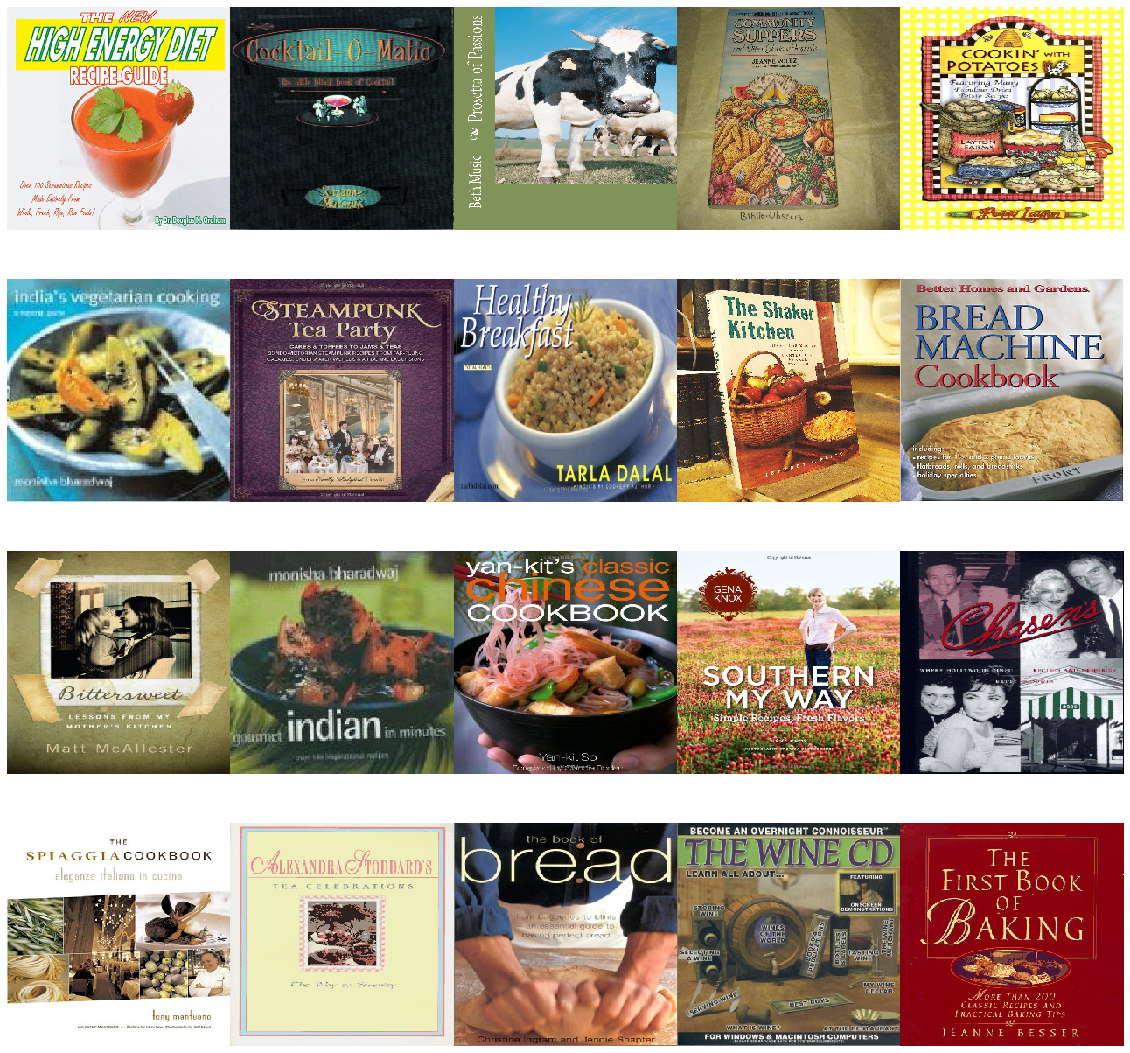

In [8]:
list_asins = np.array(data[data['wpics']==1].sample(20)['asin'])
plotCookbooks(list_asins)

In [50]:
import random

import pandas as pd
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy

ratings_matrix_file = "../data/amzn/ratings_matrix.csv"
book_ids_file = "../data/amzn/ratings_matrix_bookIDs.json"
user_ids_file = "../data/amzn/ratings_matrix_reviwerIDs.json"

books_ASIN = json.loads(open(book_ids_file).read()) #asin to idx lookup
reviewer_ID = json.loads(open(user_ids_file).read()) #reviewerID to idx lookup

review_reader = Reader(line_format="item user rating", sep=",")
cookbook_ratings = Dataset.load_from_file(ratings_matrix_file, reader = review_reader)

print(f"Number of books with reviews: {len(books_ASIN)}")
print(f"Number of users: {len(reviewer_ID)}")

raw_ratings = cookbook_ratings.raw_ratings
random.shuffle(raw_ratings)

# A = 90% of the data, B = 10% of the data
threshold = int(.9 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]
alldataset = cookbook_ratings.build_full_trainset()

cookbook_ratings.raw_ratings = A_raw_ratings  # data is now the set A

params = {'n_factors': 20, 'n_epochs':40, 'biased': True, 'lr_all': 0.005, 
          'reg_all': 0.16, 'random_state': 333, 'verbose': True
         }

trainset = cookbook_ratings.build_full_trainset()
reco_cookbooks = SVD(**params)
reco_cookbooks.fit(trainset)

# Compute biased accuracy on A
predictionsA = reco_cookbooks.test(trainset.build_testset())
print('Biased accuracy on A,', end='   ')
accuracy.rmse(predictionsA)

# Compute unbiased accuracy on B
testset = cookbook_ratings.construct_testset(B_raw_ratings)  # testset is now the set B
predictionsB = reco_cookbooks.test(testset)
print('Unbiased accuracy on B,', end=' ')
accuracy.rmse(predictionsB)

Number of books with reviews: 15782
Number of users: 210808
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Biased accuracy on A,   RMSE: 0.7252
Unbiased accuracy on B, RMSE: 0.9217


0.9216841844251459

In [51]:
print('Biased accuracy on A,', end='   ')
accuracy.mae(predictionsA)
print('Unbiased accuracy on B,', end=' ')
accuracy.mae(predictionsB)

Biased accuracy on A,   MAE:  0.5214
Unbiased accuracy on B, MAE:  0.6609


0.6609172390715053

In [13]:
raw_uid = [trainset.to_raw_uid(k) for k in trainset.ur.keys()]
print(raw_uid)

['49395', '19384', '117123', '2486', '105469', '106463', '129412', '24405', '34442', '70292', '197925', '143017', '82187', '128139', '196858', '124266', '57605', '58164', '32837', '25530', '184402', '169420', '90051', '13620', '86038', '97786', '602', '97964', '208389', '136054', '59697', '25753', '189761', '29251', '69893', '35858', '135969', '185035', '5201', '7096', '191632', '171082', '174664', '39473', '50714', '62557', '12592', '17548', '174718', '113189', '50593', '31711', '34125', '3866', '62174', '159202', '27965', '85611', '58261', '49962', '22543', '994', '33984', '139853', '9116', '8590', '17713', '56269', '141632', '79987', '5617', '138359', '56427', '87996', '27482', '171722', '209520', '104600', '12496', '2595', '7665', '9448', '68422', '62308', '64289', '172629', '25826', '14852', '133918', '2355', '132949', '98355', '49923', '74171', '54822', '39384', '21305', '21534', '202328', '82906', '88804', '145975', '193549', '85418', '22733', '85258', '33873', '17623', '196139'

In [14]:
print(f"Total number of users are: {trainset.n_users}")
print(f"Total number of books are: {trainset.n_items}")
trainset.rating_scale

Total number of users are: 197215
Total number of books are: 15782


(1, 5)

In [15]:
pred = reco_cookbooks.predict(2000,759, verbose=True)
pred = reco_cookbooks.predict(7528,127557, verbose=True)
#print(trainset.to_inner_uid(127557))
#print(trainset.to_inner_iid(7528))

user: 2000       item: 759        r_ui = None   est = 4.45   {'was_impossible': False}
user: 7528       item: 127557     r_ui = None   est = 4.45   {'was_impossible': False}


In [13]:
#𝑟̂𝑢𝑖=𝜇+𝑏𝑢+𝑏𝑖+𝑞𝑇𝑖𝑝𝑢
bu = reco_cookbooks.bu
bi = reco_cookbooks.bi
qi = reco_cookbooks.qi
pu = reco_cookbooks.pu

In [14]:
print(f"Shape of bu: {bu.shape}")
print(f"Shape of bi: {bi.shape}")
print(f"Shape of qi: {qi.shape}")
print(f"Shape of pu: {pu.shape}")

Shape of bu: (210808,)
Shape of bi: (15782,)
Shape of qi: (15782, 20)
Shape of pu: (210808, 20)


In [18]:
reco_model = (bu, bi, qi, pu)
from joblib import load, dump

dump(reco_model, "../model/reco_model.joblib")

['../model/reco_model.joblib']

In [35]:
#data[(data['title_ok']==1) * (data['desc_ok']==1) * (data['avg_ratings']>0)]['wpics']
data[(data['avg_ratings']>1) * (data['avg_ratings']<2)]

asin                                              title  \
17351  0967838258                           The New Armenian Kitchen   
18303  0981538185  Sensa Weight-Loss Program: The Accidental Disc...   
26903  1519610998  Cooking For One Cookbook: Loaded With Deliciou...   
35355  1624144675  Alternative Vegan: Healthy Plant-Based Recipes...   

                                             title_clean  title_count  \
17351                           the new armenian kitchen            4   
18303  sensa weight loss program  the accidental disc...           15   
26903  cooking for one cookbook  loaded with deliciou...           18   
35355  alternative vegan  healthy plant based recipes...           10   

                                             description  \
17351  [I put together "The New Armenian Kitchen" and...   
18303  [Hirsch, a neurologist and psychiatrist, is th...   
26903                                               [, ]   
35355  [, Alternative Vegan is the cookbook youve bee...   

                                              desc_clean  desc_count  \
17351    i put together  the new armenian kitchen  an...         318   
18303    hirsch  a neurologist and psychiatrist  is t...          18   
26903                                                              0   
35355        alternative vegan is the cookbook youve ...         174   

       title_ok  desc_ok  use_these  avg_ratings  wpics  
17351         1        1          1     1.833333      1  
18303         1        1          1     1.916667      1  
26903         1        0          0     1.800000      0  
35355         1        1          1     1.875000      0

In [36]:
books_ASIN['1624144675']

11056

In [16]:
# ---
inner2raw_uid = {k:trainset.to_raw_uid(k) for k in trainset.all_users()}
raw2inner_uid = {v:k for k,v in inner2raw_uid.items()}
# ---
inner2raw_iid = {k:trainset.to_raw_iid(k) for k in trainset.all_items()}
raw2inner_iid = {v:k for k,v in inner2raw_iid.items()}
print(raw_uid)

['49395', '19384', '117123', '2486', '105469', '106463', '129412', '24405', '34442', '70292', '197925', '143017', '82187', '128139', '196858', '124266', '57605', '58164', '32837', '25530', '184402', '169420', '90051', '13620', '86038', '97786', '602', '97964', '208389', '136054', '59697', '25753', '189761', '29251', '69893', '35858', '135969', '185035', '5201', '7096', '191632', '171082', '174664', '39473', '50714', '62557', '12592', '17548', '174718', '113189', '50593', '31711', '34125', '3866', '62174', '159202', '27965', '85611', '58261', '49962', '22543', '994', '33984', '139853', '9116', '8590', '17713', '56269', '141632', '79987', '5617', '138359', '56427', '87996', '27482', '171722', '209520', '104600', '12496', '2595', '7665', '9448', '68422', '62308', '64289', '172629', '25826', '14852', '133918', '2355', '132949', '98355', '49923', '74171', '54822', '39384', '21305', '21534', '202328', '82906', '88804', '145975', '193549', '85418', '22733', '85258', '33873', '17623', '196139'

In [79]:
reco_model = {'bu': bu,
              'bi':bi,
              'qi':qi,
              'pu': pu,
              'inner2raw_uid': inner2raw_uid,
              'raw2inner_uid': raw2inner_uid,
              'inner2raw_iid': inner2raw_iid,
              'raw2inner_iid': raw2inner_iid
             }
from joblib import load, dump

dump(reco_model, "../model/reco_model.joblib")

['../model/reco_model.joblib']

In [40]:
print(qi.shape)

(15782, 20)


In [83]:
class reco_cookbooks_model:
    def __init__(self, reco_model):
        self.bu = reco_model['bu']
        self.bi = reco_model['bi']
        self.pu = reco_model['pu']
        self.qi = reco_model['qi']
        
        self.inner2raw_uid = reco_model['inner2raw_uid']
        self.raw2inner_uid = reco_model['raw2inner_uid']
        self.inner2raw_iid = reco_model['inner2raw_iid']
        self.raw2inner_iid = reco_model['raw2inner_iid']
    
    def predict_top10(self, raw_userid, raw_itemid):
        inner_uid = self.raw2inner_uid[str(raw_userid)]
        inner_iid = self.raw2inner_iid[str(raw_itemid)]
        
        temp_pu = self.pu[inner_uid].reshape(1, -1)
        temp_bu = self.bu[inner_uid]
        #temp_bi = self.bi
        #temp_qi = self.qi
        print(temp_bu.shape)
        print(qi.T.shape)
        print(self.bi.shape)
        print(temp_bu.shape)
        
        step1 = np.matmul(temp_pu, self.qi.T)
        step2 = np.add(step1, temp_bu)
        step3 = np.add(step2, self.bi.reshape(-1, 1))
        
        return step3[inner_iid]

test = reco_cookbooks_model(reco_model)
print(test.predict_top10('51245', '1850'))
        
        

()
(20, 15782)
(15782,)
()
[-1.19426117 -1.24251492 -1.27234588 ... -1.24708647 -1.28617002
 -1.27935089]


In [18]:
#trainset.to_inner_iid('123211')
pred = reco_cookbooks.predict('88804', '5519', verbose=True)
print(A_raw_ratings[96:180])

user: 88804      item: 5519       r_ui = None   est = 4.05   {'was_impossible': False}
[('21305', '1891', 5.0, None), ('21534', '695', 5.0, None), ('202328', '8378', 1.0, None), ('82906', '3791', 5.0, None), ('88804', '5519', 2.0, None), ('145975', '9396', 5.0, None), ('193549', '4363', 5.0, None), ('85418', '4038', 4.0, None), ('22733', '739', 2.0, None), ('85258', '4028', 5.0, None), ('33873', '10566', 4.0, None), ('17623', '12724', 5.0, None), ('196139', '5489', 5.0, None), ('45067', '3516', 5.0, None), ('195201', '14092', 4.0, None), ('19653', '580', 3.0, None), ('35843', '1082', 5.0, None), ('22681', '1717', 2.0, None), ('167521', '11113', 5.0, None), ('109011', '6107', 3.0, None), ('23198', '9573', 5.0, None), ('195638', '14168', 4.0, None), ('124610', '10161', 3.0, None), ('56072', '2120', 4.0, None), ('170457', '11267', 5.0, None), ('46742', '2065', 5.0, None), ('88543', '757', 5.0, None), ('128715', '7567', 1.0, None), ('27067', '841', 5.0, None), ('22971', '9176', 5.0, None),

In [21]:
raw2ASIN = {str(v):k for k, v in books_ASIN.items()}
raw2reviewer = {str(v):k for k, v in reviewer_ID.items()}

In [52]:
def get_avg_rating(raw_iid):
    asin = raw2ASIN[raw_iid]
    return ratings_dict[asin]['avg_rating']
preds_B = [(u, i, r, get_avg_rating(i), reco_cookbooks.predict(u, i, verbose=False).est) for u, i, r, _ in B_raw_ratings]

In [53]:
actual = [i[2] for i in preds_B]
avg_rats = [i[3] for i in preds_B]
recos = [i[4] for i in preds_B]
naive = [5 for i in preds_B]

In [54]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from math import sqrt

print(f"Comparison Stats for Testset:")
print(f"1: Comparing model to actual: RMSE = {sqrt(mse(actual, recos)):.3f}, MAE = {mae(actual, recos):.3f}")
print(f"2: Comparing all 5 naive to actual: RMSE = {sqrt(mse(actual, naive)):.3f}, MAE = {mae(actual, naive):.3f}")
print(f"3: Comparing avg naive to actual: RMSE = {sqrt(mse(actual, avg_rats)):.3f}, MAE = {mae(actual, avg_rats):.3f}")

Comparison Stats for Testset:
1: Comparing model to actual: RMSE = 0.922, MAE = 0.661
2: Comparing all 5 naive to actual: RMSE = 1.132, MAE = 0.552
3: Comparing avg naive to actual: RMSE = 0.934, MAE = 0.685


In [55]:
def long_tail_plot(df, item_id_column, interaction_type, percentage=None, x_labels=True):
    """
    Plots the long tail for a user-item interaction dataset.
    ----------
    df: pandas dataframe
        user-item interaction dataframe
        example:
    item_id_column: str
        column name identifying the item ids in the dataframe
    interaction_type: str
        type of user-item interactions
        i.e. 'purchases', 'ratings' 'interactions', or 'clicks'
    percentage: float, default=None
        percent of volume to consider as the head (percent as a decimal)
        (if default=None no line will be plotted)
    x_tables bool, default=True
        if True, plot x-axis tick labels
        if False, no x-axis tick lavels will be plotted.
    Returns:
    -------
        A long tail plot
    """
    #calculate cumulative volumes
    volume_df = pd.DataFrame(df[item_id_column].value_counts())
    volume_df.reset_index(inplace=True)
    volume_df.columns = [item_id_column, "volume"]
    volume_df[item_id_column] = volume_df[item_id_column].astype(str)
    volume_df['cumulative_volume'] = volume_df['volume'].cumsum()
    volume_df['percent_of_total_volume'] = volume_df['cumulative_volume']/volume_df['volume'].sum()

    #line plot of cumulative volume
    x=range(0,len(volume_df))
    ax = sns.lineplot(x, y="volume", data=volume_df, color="black")
    plt.xticks(x)

    #set labels
    ax.set_title('Long Tail Plot')
    ax.set_ylabel('# of ' + interaction_type)
    ax.set_xlabel(item_id_column)

    if percentage != None:
        #plot vertical line at the tail location
        head = volume_df[volume_df.percent_of_total_volume <= percentage]
        tail = volume_df[volume_df.percent_of_total_volume > percentage]
        items_in_head = len(head)
        items_in_tail = len(tail)
        plt.axvline(x=items_in_head, color="red",  linestyle='--')

        # fill area under plot
        head = head.append(tail.head(1))
        x1 = head.index.values
        y1 = head['volume']
        x2 = tail.index.values
        y2 = tail['volume']
        ax.fill_between(x1, y1, color="blue", alpha=0.2)
        ax.fill_between(x2, y2,  color="orange", alpha=0.2)

        #create legend
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(items_in_head)+': items in the head', markerfacecolor='blue', markersize=5),
                           Line2D([0], [0], marker='o', color='w', label=str(items_in_tail)+': items in the tail', markerfacecolor='orange', markersize=5)]
        ax.legend(handles=legend_elements, loc=1)

    else:
        x1 = volume_df[item_id_column]
        y1 = volume_df['volume']
        ax.fill_between(x1, y1, color="blue", alpha=0.3)
    if x_labels == False:
        plt.xticks([], [])
        ax.set(xticklabels=[])
    else:
        ax.set_xticklabels(labels = volume_df[item_id_column], rotation = 45, ha="right")

    plt.show()

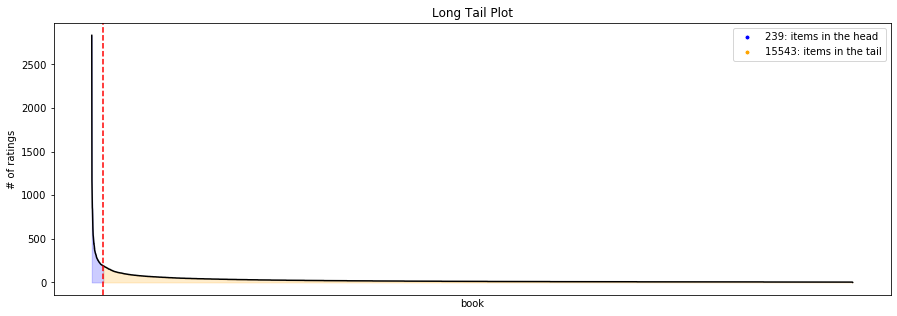

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.rcParams['figure.figsize'] = [15, 5]
ratings = pd.read_csv(ratings_matrix_file, header=0, names=["book", "user", "volume"])
long_tail_plot(ratings, "book", "ratings", percentage=0.2, x_labels=False)